모듈 로드

In [119]:
# Utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
! pip install tensorboardX
from tensorboardX import SummaryWriter

# sklearn
from sklearn.metrics import confusion_matrix, classification_report

하이퍼파라미터 설정

In [120]:
batch_size = 128
num_epochs = 10
learning_rate = 0.0001

데이터 불러오기 (CIFAR10)

In [121]:
train_set = torchvision.datasets.ImageFolder(root='./Bird/train',  transform=transforms.ToTensor())
test_set = torchvision.datasets.ImageFolder(root='./Bird/test', transform=transforms.ToTensor())

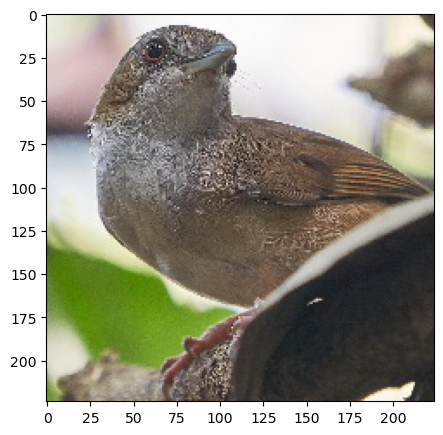

In [122]:
dataiter = iter(train_set)
images, labels = next(dataiter)

img   = make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(5, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

RGB 채널 감소

In [123]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_set]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_set]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(train_stdR, train_stdG, train_stdB)

0.4739998 0.46928418 0.3956359
0.2038732 0.20068747 0.20583461


이미지 전처리

In [124]:
train_transformer = transforms.Compose([
                                        transforms.CenterCrop(227),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[train_meanR, train_meanG, train_meanB], 
                                                             std=[train_stdR, train_stdG, train_stdB])])

train_set.transform = train_transformer
test_set.transform = train_transformer

In [125]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

AlexNet 모델

In [126]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=525),
            nn.LogSoftmax(dim=1)
        )

        self.apply(self._init_weight_bias)

    def _init_weight_bias(self, module):
        classname = module.__class__.__name__
        if classname == 'Conv2d':
            nn.init.normal_(module.weight, mean=0.0, std=0.01)
            nn.init.constant_(module.bias, 0)
            if (module.in_channels == 96 or module.in_channels == 384):
              nn.init.constant_(module.bias, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [127]:
use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")

net = AlexNet().to(device)

X = torch.randn(size=(1,3,227,227)).type(FloatTensor)
print(net(X))
print(summary(net, (3,227,227)))

use_cuda :  True
tensor([[-5.9431, -6.1841, -6.1788, -6.5625, -6.4053, -6.3034, -6.0030, -6.1151,
         -5.7396, -6.1809, -6.5458, -6.1406, -6.2508, -6.2960, -5.9702, -6.1269,
         -6.3715, -5.9144, -6.2665, -6.0063, -6.2998, -6.3011, -6.6324, -5.9330,
         -6.5566, -6.2396, -6.2823, -6.2345, -6.0568, -6.4428, -6.2013, -6.0821,
         -5.9564, -6.3193, -6.6903, -6.3017, -6.4937, -6.1706, -6.6838, -6.3247,
         -6.4796, -6.5157, -6.1838, -6.3795, -6.2179, -6.4019, -6.1760, -6.3330,
         -6.4053, -6.1482, -6.3277, -6.1545, -6.5207, -6.5121, -6.0418, -6.1356,
         -6.4577, -6.3297, -6.0514, -5.9285, -6.4324, -5.9818, -6.5555, -6.0746,
         -6.5616, -6.1602, -6.5757, -6.1888, -6.4675, -6.1915, -5.9686, -6.3275,
         -6.3964, -6.0903, -6.5982, -6.1568, -6.5582, -6.3330, -6.6474, -6.0878,
         -6.5599, -6.4145, -6.4422, -6.1548, -6.5029, -6.0516, -5.6494, -6.8341,
         -6.7152, -5.9133, -6.3125, -6.1787, -6.1900, -5.9190, -6.2695, -6.2945,
         -6

GPU 사용 여부

In [128]:
use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

use_cuda :  True


Tensorboard를 통해서 훈련 손실과 정확도를 기록한다

In [129]:
writer = SummaryWriter("./alexnet/tensorboard")

In [130]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 30 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]")

In [131]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # 여기서 'reduction' 인자 제거
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [132]:
# 학습 및 테스트 수행
results = []
for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, device, trainloader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, testloader)
    writer.add_scalar("Test Loss", test_loss, epoch)
    writer.add_scalar("Test Accuracy", test_accuracy, epoch)
    print(f"Epoch: {epoch}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    results.append([epoch,test_loss,test_accuracy])
    writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/84635]
Train Epoch: 1 [3840/84635]
Train Epoch: 1 [7680/84635]
Train Epoch: 1 [11520/84635]
Train Epoch: 1 [15360/84635]
Train Epoch: 1 [19200/84635]
Train Epoch: 1 [23040/84635]
Train Epoch: 1 [26880/84635]
Train Epoch: 1 [30720/84635]
Train Epoch: 1 [34560/84635]
Train Epoch: 1 [38400/84635]
Train Epoch: 1 [42240/84635]
Train Epoch: 1 [46080/84635]
Train Epoch: 1 [49920/84635]
Train Epoch: 1 [53760/84635]
Train Epoch: 1 [57600/84635]
Train Epoch: 1 [61440/84635]
Train Epoch: 1 [65280/84635]
Train Epoch: 1 [69120/84635]
Train Epoch: 1 [72960/84635]
Train Epoch: 1 [76800/84635]
Train Epoch: 1 [80640/84635]
Train Epoch: 1 [84480/84635]


 10%|█         | 1/10 [01:15<11:15, 75.01s/it]

Epoch: 1, Test Loss: 0.050114928654261995, Test Accuracy: 0.0019047619047619048
Train Epoch: 2 [0/84635]
Train Epoch: 2 [3840/84635]
Train Epoch: 2 [7680/84635]
Train Epoch: 2 [11520/84635]
Train Epoch: 2 [15360/84635]
Train Epoch: 2 [19200/84635]
Train Epoch: 2 [23040/84635]
Train Epoch: 2 [26880/84635]
Train Epoch: 2 [30720/84635]
Train Epoch: 2 [34560/84635]
Train Epoch: 2 [38400/84635]
Train Epoch: 2 [42240/84635]
Train Epoch: 2 [46080/84635]
Train Epoch: 2 [49920/84635]
Train Epoch: 2 [53760/84635]
Train Epoch: 2 [57600/84635]
Train Epoch: 2 [61440/84635]
Train Epoch: 2 [65280/84635]
Train Epoch: 2 [69120/84635]
Train Epoch: 2 [72960/84635]
Train Epoch: 2 [76800/84635]
Train Epoch: 2 [80640/84635]
Train Epoch: 2 [84480/84635]


 20%|██        | 2/10 [02:30<10:01, 75.13s/it]

Epoch: 2, Test Loss: 0.050115033467610676, Test Accuracy: 0.0019047619047619048
Train Epoch: 3 [0/84635]
Train Epoch: 3 [3840/84635]
Train Epoch: 3 [7680/84635]
Train Epoch: 3 [11520/84635]
Train Epoch: 3 [15360/84635]
Train Epoch: 3 [19200/84635]
Train Epoch: 3 [23040/84635]
Train Epoch: 3 [26880/84635]
Train Epoch: 3 [30720/84635]
Train Epoch: 3 [34560/84635]
Train Epoch: 3 [38400/84635]
Train Epoch: 3 [42240/84635]
Train Epoch: 3 [46080/84635]
Train Epoch: 3 [49920/84635]
Train Epoch: 3 [53760/84635]
Train Epoch: 3 [57600/84635]
Train Epoch: 3 [61440/84635]
Train Epoch: 3 [65280/84635]
Train Epoch: 3 [69120/84635]
Train Epoch: 3 [72960/84635]
Train Epoch: 3 [76800/84635]
Train Epoch: 3 [80640/84635]
Train Epoch: 3 [84480/84635]


 30%|███       | 3/10 [03:45<08:45, 75.13s/it]

Epoch: 3, Test Loss: 0.05012028140113467, Test Accuracy: 0.0019047619047619048
Train Epoch: 4 [0/84635]
Train Epoch: 4 [3840/84635]
Train Epoch: 4 [7680/84635]
Train Epoch: 4 [11520/84635]
Train Epoch: 4 [15360/84635]
Train Epoch: 4 [19200/84635]
Train Epoch: 4 [23040/84635]
Train Epoch: 4 [26880/84635]
Train Epoch: 4 [30720/84635]
Train Epoch: 4 [34560/84635]
Train Epoch: 4 [38400/84635]
Train Epoch: 4 [42240/84635]
Train Epoch: 4 [46080/84635]
Train Epoch: 4 [49920/84635]
Train Epoch: 4 [53760/84635]
Train Epoch: 4 [57600/84635]
Train Epoch: 4 [61440/84635]
Train Epoch: 4 [65280/84635]
Train Epoch: 4 [69120/84635]
Train Epoch: 4 [72960/84635]
Train Epoch: 4 [76800/84635]
Train Epoch: 4 [80640/84635]
Train Epoch: 4 [84480/84635]


 40%|████      | 4/10 [05:01<07:33, 75.66s/it]

Epoch: 4, Test Loss: 0.05014073780604771, Test Accuracy: 0.0019047619047619048
Train Epoch: 5 [0/84635]
Train Epoch: 5 [3840/84635]
Train Epoch: 5 [7680/84635]
Train Epoch: 5 [11520/84635]
Train Epoch: 5 [15360/84635]
Train Epoch: 5 [19200/84635]
Train Epoch: 5 [23040/84635]
Train Epoch: 5 [26880/84635]
Train Epoch: 5 [30720/84635]
Train Epoch: 5 [34560/84635]
Train Epoch: 5 [38400/84635]
Train Epoch: 5 [42240/84635]
Train Epoch: 5 [46080/84635]
Train Epoch: 5 [49920/84635]
Train Epoch: 5 [53760/84635]
Train Epoch: 5 [57600/84635]
Train Epoch: 5 [61440/84635]
Train Epoch: 5 [65280/84635]
Train Epoch: 5 [69120/84635]
Train Epoch: 5 [72960/84635]
Train Epoch: 5 [76800/84635]
Train Epoch: 5 [80640/84635]
Train Epoch: 5 [84480/84635]


 50%|█████     | 5/10 [06:16<06:16, 75.37s/it]

Epoch: 5, Test Loss: 0.050114865075974235, Test Accuracy: 0.0019047619047619048
Train Epoch: 6 [0/84635]
Train Epoch: 6 [3840/84635]
Train Epoch: 6 [7680/84635]
Train Epoch: 6 [11520/84635]
Train Epoch: 6 [15360/84635]
Train Epoch: 6 [19200/84635]
Train Epoch: 6 [23040/84635]
Train Epoch: 6 [26880/84635]
Train Epoch: 6 [30720/84635]
Train Epoch: 6 [34560/84635]
Train Epoch: 6 [38400/84635]
Train Epoch: 6 [42240/84635]
Train Epoch: 6 [46080/84635]
Train Epoch: 6 [49920/84635]
Train Epoch: 6 [53760/84635]
Train Epoch: 6 [57600/84635]
Train Epoch: 6 [61440/84635]
Train Epoch: 6 [65280/84635]
Train Epoch: 6 [69120/84635]
Train Epoch: 6 [72960/84635]
Train Epoch: 6 [76800/84635]
Train Epoch: 6 [80640/84635]
Train Epoch: 6 [84480/84635]


 60%|██████    | 6/10 [07:32<05:02, 75.53s/it]

Epoch: 6, Test Loss: 0.050114300682431175, Test Accuracy: 0.0019047619047619048
Train Epoch: 7 [0/84635]
Train Epoch: 7 [3840/84635]
Train Epoch: 7 [7680/84635]
Train Epoch: 7 [11520/84635]
Train Epoch: 7 [15360/84635]
Train Epoch: 7 [19200/84635]
Train Epoch: 7 [23040/84635]
Train Epoch: 7 [26880/84635]
Train Epoch: 7 [30720/84635]
Train Epoch: 7 [34560/84635]
Train Epoch: 7 [38400/84635]
Train Epoch: 7 [42240/84635]
Train Epoch: 7 [46080/84635]
Train Epoch: 7 [49920/84635]
Train Epoch: 7 [53760/84635]
Train Epoch: 7 [57600/84635]
Train Epoch: 7 [61440/84635]
Train Epoch: 7 [65280/84635]
Train Epoch: 7 [69120/84635]
Train Epoch: 7 [72960/84635]
Train Epoch: 7 [76800/84635]
Train Epoch: 7 [80640/84635]
Train Epoch: 7 [84480/84635]


 70%|███████   | 7/10 [08:48<03:46, 75.63s/it]

Epoch: 7, Test Loss: 0.05011421821230934, Test Accuracy: 0.0019047619047619048
Train Epoch: 8 [0/84635]
Train Epoch: 8 [3840/84635]
Train Epoch: 8 [7680/84635]
Train Epoch: 8 [11520/84635]
Train Epoch: 8 [15360/84635]
Train Epoch: 8 [19200/84635]
Train Epoch: 8 [23040/84635]
Train Epoch: 8 [26880/84635]
Train Epoch: 8 [30720/84635]
Train Epoch: 8 [34560/84635]
Train Epoch: 8 [38400/84635]
Train Epoch: 8 [42240/84635]
Train Epoch: 8 [46080/84635]
Train Epoch: 8 [49920/84635]
Train Epoch: 8 [53760/84635]
Train Epoch: 8 [57600/84635]
Train Epoch: 8 [61440/84635]
Train Epoch: 8 [65280/84635]
Train Epoch: 8 [69120/84635]
Train Epoch: 8 [72960/84635]
Train Epoch: 8 [76800/84635]
Train Epoch: 8 [80640/84635]
Train Epoch: 8 [84480/84635]


 80%|████████  | 8/10 [10:03<02:30, 75.43s/it]

Epoch: 8, Test Loss: 0.05011404709588914, Test Accuracy: 0.0019047619047619048
Train Epoch: 9 [0/84635]
Train Epoch: 9 [3840/84635]
Train Epoch: 9 [7680/84635]
Train Epoch: 9 [11520/84635]
Train Epoch: 9 [15360/84635]
Train Epoch: 9 [19200/84635]
Train Epoch: 9 [23040/84635]
Train Epoch: 9 [26880/84635]
Train Epoch: 9 [30720/84635]
Train Epoch: 9 [34560/84635]
Train Epoch: 9 [38400/84635]
Train Epoch: 9 [42240/84635]
Train Epoch: 9 [46080/84635]
Train Epoch: 9 [49920/84635]
Train Epoch: 9 [53760/84635]
Train Epoch: 9 [57600/84635]
Train Epoch: 9 [61440/84635]
Train Epoch: 9 [65280/84635]
Train Epoch: 9 [69120/84635]
Train Epoch: 9 [72960/84635]
Train Epoch: 9 [76800/84635]
Train Epoch: 9 [80640/84635]
Train Epoch: 9 [84480/84635]


 90%|█████████ | 9/10 [11:19<01:15, 75.64s/it]

Epoch: 9, Test Loss: 0.05011388742356073, Test Accuracy: 0.0019047619047619048
Train Epoch: 10 [0/84635]
Train Epoch: 10 [3840/84635]
Train Epoch: 10 [7680/84635]
Train Epoch: 10 [11520/84635]
Train Epoch: 10 [15360/84635]
Train Epoch: 10 [19200/84635]
Train Epoch: 10 [23040/84635]
Train Epoch: 10 [26880/84635]
Train Epoch: 10 [30720/84635]
Train Epoch: 10 [34560/84635]
Train Epoch: 10 [38400/84635]
Train Epoch: 10 [42240/84635]
Train Epoch: 10 [46080/84635]
Train Epoch: 10 [49920/84635]
Train Epoch: 10 [53760/84635]
Train Epoch: 10 [57600/84635]
Train Epoch: 10 [61440/84635]
Train Epoch: 10 [65280/84635]
Train Epoch: 10 [69120/84635]
Train Epoch: 10 [72960/84635]
Train Epoch: 10 [76800/84635]
Train Epoch: 10 [80640/84635]
Train Epoch: 10 [84480/84635]


100%|██████████| 10/10 [12:34<00:00, 75.47s/it]

Epoch: 10, Test Loss: 0.05011376135689872, Test Accuracy: 0.0019047619047619048


In [133]:
for result in results : 
    print(f"Result {result[0]}, Loss : {result[1]} Accuracy : {result[2]}")

Result 1, Loss : 0.050114928654261995 Accuracy : 0.0019047619047619048
Result 2, Loss : 0.050115033467610676 Accuracy : 0.0019047619047619048
Result 3, Loss : 0.05012028140113467 Accuracy : 0.0019047619047619048
Result 4, Loss : 0.05014073780604771 Accuracy : 0.0019047619047619048
Result 5, Loss : 0.050114865075974235 Accuracy : 0.0019047619047619048
Result 6, Loss : 0.050114300682431175 Accuracy : 0.0019047619047619048
Result 7, Loss : 0.05011421821230934 Accuracy : 0.0019047619047619048
Result 8, Loss : 0.05011404709588914 Accuracy : 0.0019047619047619048
Result 9, Loss : 0.05011388742356073 Accuracy : 0.0019047619047619048
Result 10, Loss : 0.05011376135689872 Accuracy : 0.0019047619047619048


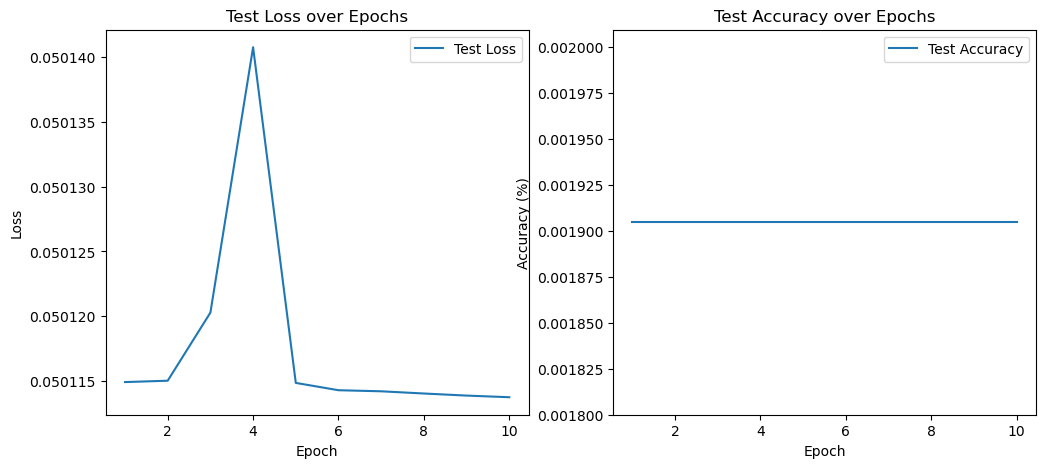

In [134]:
import matplotlib.pyplot as plt

epochs = [x[0] for x in results]
losses = [x[1] for x in results]
accuracies = [x[2] for x in results]

plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test Loss over Epochs")
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy over Epochs")
plt.legend()

plt.show()

In [135]:
%load_ext tensorboard
%tensorboard --logdir=./alexnet/tensorboard --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 36020), started 2 days, 22:04:51 ago. (Use '!kill 36020' to kill it.)